In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
w,h=10,10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Utils

In [3]:
def delete_index(T, index=None):
    if index is None:
        return T
    elif index is -1:
        return T[:index]
    else:
        return torch.cat([T[:index], T[index+1:]])
delete_index(torch.arange(30).reshape(3,10), 1), \
delete_index(torch.arange(30).reshape(3,10)), \
delete_index(torch.arange(30).reshape(3,10), -1)

(tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
         [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]),
 tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
         [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]),
 tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]))

In [4]:
def jump_bound(position):
    if position[0] >= w:
        position[0] = position[0] - w
    elif position[0] < 0:
        position[0] = w + position[0]
    if position[1] >= h:
        position[1] = position[1] - w
    elif position[1] < 0:
        position[1] = h + position[1]
    return position
jump_bound([10, -1])

[0, 9]

### Env

In [5]:
class MomentumObject:
    def __init__(self, w, h, device):
        self.w, self.h = w,h
        self.position = torch.zeros((2), dtype=torch.int).to(device)
        self.speed = torch.randint(-2, 2, size=(2,)).to(device)
    def get_state_action(self):
        return torch.cat((self.position, self.speed)).type(torch.float64)
    def step(self):
        self.position += self.speed
        jump_bound(self.position)
        self.speed = torch.randint(-2, 2, size=(2,)).to(device)
    def render(self, predict_position=None):
        state = torch.zeros((w,h))
        state[self.position[0], self.position[1]] = 1
        if predict_position is not None:
            predict_position = predict_position.type(torch.int)
            state[predict_position[0], predict_position[1]] = 0.2
        return state
momentum_object = MomentumObject(w, h, device)
momentum_object.step()
momentum_object.render()

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [6]:
num_buffer = 128
dimension_state = 2
num_state = momentum_object.position.shape[0] + momentum_object.speed.shape[0]
states_actions = torch.zeros((num_buffer, num_state), dtype=torch.float64).to(device)

def update_state_buffer(states_actions, current_state_action, remove_index):
    current_state_action = torch.unsqueeze(current_state_action, 0)
    states_actions = delete_index(states_actions, remove_index)
    return torch.cat((current_state_action, states_actions)).detach()
for i in range(num_buffer):
    momentum_object.step()
    states_actions = update_state_buffer(states_actions, momentum_object.get_state_action(), remove_index=-1)
states_actions

tensor([[ 2.,  9.,  1., -2.],
        [ 2.,  1.,  0., -2.],
        [ 3.,  1., -1.,  0.],
        [ 4.,  2., -1., -1.],
        [ 3.,  4.,  1., -2.],
        [ 4.,  5., -1., -1.],
        [ 5.,  4., -1.,  1.],
        [ 4.,  4.,  1.,  0.],
        [ 5.,  6., -1., -2.],
        [ 6.,  5., -1.,  1.],
        [ 8.,  5., -2.,  0.],
        [ 9.,  6., -1., -1.],
        [ 1.,  5., -2.,  1.],
        [ 3.,  4., -2.,  1.],
        [ 3.,  3.,  0.,  1.],
        [ 2.,  3.,  1.,  0.],
        [ 2.,  3.,  0.,  0.],
        [ 2.,  3.,  0.,  0.],
        [ 4.,  2., -2.,  1.],
        [ 4.,  3.,  0., -1.],
        [ 5.,  4., -1., -1.],
        [ 7.,  3., -2.,  1.],
        [ 8.,  5., -1., -2.],
        [ 7.,  7.,  1., -2.],
        [ 9.,  8., -2., -1.],
        [ 9.,  7.,  0.,  1.],
        [ 9.,  8.,  0., -1.],
        [ 0.,  8., -1.,  0.],
        [ 0.,  9.,  0., -1.],
        [ 2.,  0., -2., -1.],
        [ 1.,  0.,  1.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 1.,  9., -1.,  1.],
        [ 

In [ ]:
def standardize_state(state):
    ''' [-4.5, 4.5] '''
    state = torch.clone(state)
    state[:, 0] = state[:, 0] - ((w-1)/2)
    state[:, 1] = state[:, 1] - ((h-1)/2)
    return state
def normalize_state(state):
    ''' [0, 1] '''
    state[:, 0] = state[:, 0]/(w-1)
    state[:, 1] = state[:, 1]/(h-1)

In [7]:
def train(i, encoder, states_actions, optimizer_encoder):
    encoder.train()
    optimizer_encoder.zero_grad()
    
    current_state = torch.clone(states_actions[1:])
    next_state = torch.clone(states_actions[:-1, :2])
    _next_state = torch.clone(next_state)
    
#     current_state[:, 0] = current_state[:, 0] - ((w-1)/2)
#     current_state[:, 1] = current_state[:, 1] - ((h-1)/2)
    _next_state[:, 0] = next_state[:, 0]/(w-1)
    _next_state[:, 1] = next_state[:, 1]/(h-1)
    
    predict_position = encoder(current_state)
    loss = mse_loss(predict_position, _next_state)
    
    _predict_position = torch.clone(predict_position).detach()
    print('_predict_position', _predict_position.shape)
    _predict_position[:,0] = _predict_position[:, 0] * (w-1)
    _predict_position[:,1] = _predict_position[:, 1] * (h-1)
    _predict_position = torch.round(_predict_position)
    miss_distance = (next_state - _predict_position).float().sum().cpu().detach().numpy()
    print("loss[", i,"]:", loss.mean().cpu().detach().numpy(), 'miss_distance', miss_distance)
    
    loss.mean().backward()
    optimizer_encoder.step()
    
    return torch.argmin(loss.mean(axis=1)).type(torch.int)
    
torch.manual_seed(1)
encoder = nn.Sequential(
                nn.Linear(4,16),
                nn.ReLU(),
                nn.Linear(16,32),
                nn.ReLU(),
                nn.Linear(32,8),
                nn.ReLU(),
                nn.Linear(8,2),
                nn.Sigmoid()).to(device).to(torch.float64)

optimizer_encoder = optim.Adam(encoder.parameters(), lr=0.001)
mse_loss = nn.MSELoss(reduction='none')

lowest_loss_index = None
for i in range(5000):
    momentum_object.step()
    states_actions=update_state_buffer(states_actions, momentum_object.get_state_action(), -1) # 
    lowest_loss_index = train(i, encoder, states_actions, optimizer_encoder)
    


_predict_position torch.Size([127, 2])
loss[ 0 ]: 0.12243947020898509 acc 47.0
_predict_position torch.Size([127, 2])
loss[ 1 ]: 0.12213317098811972 acc 49.0
_predict_position torch.Size([127, 2])
loss[ 2 ]: 0.1222944718882974 acc 43.0
_predict_position torch.Size([127, 2])
loss[ 3 ]: 0.12215231908393244 acc 40.0
_predict_position torch.Size([127, 2])
loss[ 4 ]: 0.12282540436491698 acc 37.0
_predict_position torch.Size([127, 2])
loss[ 5 ]: 0.12346266410044496 acc 32.0
_predict_position torch.Size([127, 2])
loss[ 6 ]: 0.12323160589529342 acc 30.0
_predict_position torch.Size([127, 2])
loss[ 7 ]: 0.12294088898498746 acc 30.0
_predict_position torch.Size([127, 2])
loss[ 8 ]: 0.1218328094937432 acc 31.0
_predict_position torch.Size([127, 2])
loss[ 9 ]: 0.12024306404654912 acc 32.0
_predict_position torch.Size([127, 2])
loss[ 10 ]: 0.1194474479780437 acc 23.0
_predict_position torch.Size([127, 2])
loss[ 11 ]: 0.1178719921035396 acc 24.0
_predict_position torch.Size([127, 2])
loss[ 12 ]: 0.1

_predict_position torch.Size([127, 2])
loss[ 120 ]: 0.06060231980688179 acc -19.0
_predict_position torch.Size([127, 2])
loss[ 121 ]: 0.06061533637287358 acc -25.0
_predict_position torch.Size([127, 2])
loss[ 122 ]: 0.060483192760725994 acc -27.0
_predict_position torch.Size([127, 2])
loss[ 123 ]: 0.06031105259455312 acc -25.0
_predict_position torch.Size([127, 2])
loss[ 124 ]: 0.059852549499926286 acc -22.0
_predict_position torch.Size([127, 2])
loss[ 125 ]: 0.05969043048112154 acc -22.0
_predict_position torch.Size([127, 2])
loss[ 126 ]: 0.06034005895056688 acc -18.0
_predict_position torch.Size([127, 2])
loss[ 127 ]: 0.06031351804343077 acc -21.0
_predict_position torch.Size([127, 2])
loss[ 128 ]: 0.06007735573496444 acc -17.0
_predict_position torch.Size([127, 2])
loss[ 129 ]: 0.05973876741010154 acc -13.0
_predict_position torch.Size([127, 2])
loss[ 130 ]: 0.059728740279026776 acc -11.0
_predict_position torch.Size([127, 2])
loss[ 131 ]: 0.05935400104964547 acc -7.0
_predict_posit

loss[ 250 ]: 0.056095280362508784 acc -8.0
_predict_position torch.Size([127, 2])
loss[ 251 ]: 0.05633314481961725 acc -10.0
_predict_position torch.Size([127, 2])
loss[ 252 ]: 0.05599227753043284 acc -11.0
_predict_position torch.Size([127, 2])
loss[ 253 ]: 0.05684559192352264 acc -22.0
_predict_position torch.Size([127, 2])
loss[ 254 ]: 0.05730316415514383 acc -22.0
_predict_position torch.Size([127, 2])
loss[ 255 ]: 0.05736155257638349 acc -23.0
_predict_position torch.Size([127, 2])
loss[ 256 ]: 0.06019577056048594 acc -30.0
_predict_position torch.Size([127, 2])
loss[ 257 ]: 0.06134241427675774 acc -33.0
_predict_position torch.Size([127, 2])
loss[ 258 ]: 0.06179899115491835 acc -32.0
_predict_position torch.Size([127, 2])
loss[ 259 ]: 0.06234542971108793 acc -37.0
_predict_position torch.Size([127, 2])
loss[ 260 ]: 0.06235933345664872 acc -39.0
_predict_position torch.Size([127, 2])
loss[ 261 ]: 0.0632504384956978 acc -28.0
_predict_position torch.Size([127, 2])
loss[ 262 ]: 0.06

loss[ 378 ]: 0.040630902792069296 acc 11.0
_predict_position torch.Size([127, 2])
loss[ 379 ]: 0.04028762775878654 acc 6.0
_predict_position torch.Size([127, 2])
loss[ 380 ]: 0.03924665270077512 acc 6.0
_predict_position torch.Size([127, 2])
loss[ 381 ]: 0.039586151143066434 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 382 ]: 0.038588696512522745 acc -8.0
_predict_position torch.Size([127, 2])
loss[ 383 ]: 0.038136836175015856 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 384 ]: 0.03898847564384442 acc 10.0
_predict_position torch.Size([127, 2])
loss[ 385 ]: 0.03922580296304979 acc 18.0
_predict_position torch.Size([127, 2])
loss[ 386 ]: 0.03894467326453376 acc 22.0
_predict_position torch.Size([127, 2])
loss[ 387 ]: 0.03847991814635453 acc 22.0
_predict_position torch.Size([127, 2])
loss[ 388 ]: 0.0370327788726585 acc 19.0
_predict_position torch.Size([127, 2])
loss[ 389 ]: 0.036352558803776976 acc 10.0
_predict_position torch.Size([127, 2])
loss[ 390 ]: 0.035496257376

loss[ 512 ]: 0.017154749553332373 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 513 ]: 0.017018257811369952 acc 2.0
_predict_position torch.Size([127, 2])
loss[ 514 ]: 0.016846901987633993 acc 5.0
_predict_position torch.Size([127, 2])
loss[ 515 ]: 0.017393769768488977 acc 2.0
_predict_position torch.Size([127, 2])
loss[ 516 ]: 0.017184713434517433 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 517 ]: 0.017898831775152665 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 518 ]: 0.020342850849582185 acc -13.0
_predict_position torch.Size([127, 2])
loss[ 519 ]: 0.020694596647733755 acc -10.0
_predict_position torch.Size([127, 2])
loss[ 520 ]: 0.023051169887222018 acc -11.0
_predict_position torch.Size([127, 2])
loss[ 521 ]: 0.0227343459592292 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 522 ]: 0.022446109966218406 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 523 ]: 0.022170410442311203 acc 9.0
_predict_position torch.Size([127, 2])
loss[ 524 ]: 0.02288

_predict_position torch.Size([127, 2])
loss[ 625 ]: 0.012716207883691167 acc 9.0
_predict_position torch.Size([127, 2])
loss[ 626 ]: 0.012479017937625382 acc 4.0
_predict_position torch.Size([127, 2])
loss[ 627 ]: 0.012367165674193088 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 628 ]: 0.012194405965863115 acc -14.0
_predict_position torch.Size([127, 2])
loss[ 629 ]: 0.011947526037656185 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 630 ]: 0.011517161974963783 acc 9.0
_predict_position torch.Size([127, 2])
loss[ 631 ]: 0.011405173807558058 acc 17.0
_predict_position torch.Size([127, 2])
loss[ 632 ]: 0.011448917104944663 acc 23.0
_predict_position torch.Size([127, 2])
loss[ 633 ]: 0.011374670876867164 acc 17.0
_predict_position torch.Size([127, 2])
loss[ 634 ]: 0.011364809002160971 acc 6.0
_predict_position torch.Size([127, 2])
loss[ 635 ]: 0.011237641483228597 acc 2.0
_predict_position torch.Size([127, 2])
loss[ 636 ]: 0.011096889480101905 acc 4.0
_predict_position tor

_predict_position torch.Size([127, 2])
loss[ 739 ]: 0.014223860712921262 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 740 ]: 0.013996877255247744 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 741 ]: 0.013777841055549647 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 742 ]: 0.013601909279113833 acc -10.0
_predict_position torch.Size([127, 2])
loss[ 743 ]: 0.013353690791721325 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 744 ]: 0.012996202656567781 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 745 ]: 0.0127577902677553 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 746 ]: 0.012591420053172481 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 747 ]: 0.012463864107334422 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 748 ]: 0.012313191688877845 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 749 ]: 0.012182456334774962 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 750 ]: 0.01209515388556234 acc -8.0
_predict_position torc

_predict_position torch.Size([127, 2])
loss[ 865 ]: 0.007702992991453071 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 866 ]: 0.00769003803776982 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 867 ]: 0.007634549343830533 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 868 ]: 0.007588968921658877 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 869 ]: 0.007603887961432967 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 870 ]: 0.007544945267336805 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 871 ]: 0.007514697352476817 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 872 ]: 0.007512683553543334 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 873 ]: 0.007473034874993915 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 874 ]: 0.007480471526159905 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 875 ]: 0.007465024863789858 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 876 ]: 0.010747060825964463 acc -10.0
_predict_position

_predict_position torch.Size([127, 2])
loss[ 997 ]: 0.009505157607307337 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 998 ]: 0.00937853698905125 acc 6.0
_predict_position torch.Size([127, 2])
loss[ 999 ]: 0.009208722771086421 acc 9.0
_predict_position torch.Size([127, 2])
loss[ 1000 ]: 0.009048912080086003 acc 4.0
_predict_position torch.Size([127, 2])
loss[ 1001 ]: 0.009192492395147167 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 1002 ]: 0.009012507238269704 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 1003 ]: 0.006965739244005787 acc 6.0
_predict_position torch.Size([127, 2])
loss[ 1004 ]: 0.006909353858386998 acc 5.0
_predict_position torch.Size([127, 2])
loss[ 1005 ]: 0.006697049763209864 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 1006 ]: 0.006588728119281232 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 1007 ]: 0.006442676727007189 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 1008 ]: 0.006291421040148079 acc 0.0
_predict_positio

_predict_position torch.Size([127, 2])
loss[ 1125 ]: 0.008587325694998227 acc -9.0
_predict_position torch.Size([127, 2])
loss[ 1126 ]: 0.008469149863016504 acc -8.0
_predict_position torch.Size([127, 2])
loss[ 1127 ]: 0.008374869829429853 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 1128 ]: 0.008265261542191659 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 1129 ]: 0.008211242184140148 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 1130 ]: 0.008196188020178309 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 1131 ]: 0.008445249762012644 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 1132 ]: 0.008339384889329298 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 1133 ]: 0.008209957320824064 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 1134 ]: 0.008053672471568006 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 1135 ]: 0.007887625755590067 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 1136 ]: 0.007799056467156078 acc 3.0
_predic

_predict_position torch.Size([127, 2])
loss[ 1260 ]: 0.005953942965829705 acc -9.0
_predict_position torch.Size([127, 2])
loss[ 1261 ]: 0.005939831511248503 acc -9.0
_predict_position torch.Size([127, 2])
loss[ 1262 ]: 0.006062647201157184 acc -8.0
_predict_position torch.Size([127, 2])
loss[ 1263 ]: 0.00598065704947278 acc -9.0
_predict_position torch.Size([127, 2])
loss[ 1264 ]: 0.005912679807985664 acc -11.0
_predict_position torch.Size([127, 2])
loss[ 1265 ]: 0.005845465200825346 acc -8.0
_predict_position torch.Size([127, 2])
loss[ 1266 ]: 0.005721213190852038 acc -11.0
_predict_position torch.Size([127, 2])
loss[ 1267 ]: 0.005442898067027596 acc -13.0
_predict_position torch.Size([127, 2])
loss[ 1268 ]: 0.005117834464469804 acc -11.0
_predict_position torch.Size([127, 2])
loss[ 1269 ]: 0.004986598193053966 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 1270 ]: 0.004876483120942989 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 1271 ]: 0.004734001048547538 acc -2.0
_

_predict_position torch.Size([127, 2])
loss[ 1381 ]: 0.006022366896202709 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 1382 ]: 0.005747545956626187 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 1383 ]: 0.005558105400857518 acc -8.0
_predict_position torch.Size([127, 2])
loss[ 1384 ]: 0.005369041440810614 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 1385 ]: 0.005864318067815993 acc 7.0
_predict_position torch.Size([127, 2])
loss[ 1386 ]: 0.007292272051771535 acc 6.0
_predict_position torch.Size([127, 2])
loss[ 1387 ]: 0.010780521221579352 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 1388 ]: 0.010609060532402162 acc 5.0
_predict_position torch.Size([127, 2])
loss[ 1389 ]: 0.010306058145397395 acc 13.0
_predict_position torch.Size([127, 2])
loss[ 1390 ]: 0.010249547609779126 acc 18.0
_predict_position torch.Size([127, 2])
loss[ 1391 ]: 0.010240005489518589 acc 16.0
_predict_position torch.Size([127, 2])
loss[ 1392 ]: 0.013166369557495056 acc 14.0
_predic

_predict_position torch.Size([127, 2])
loss[ 1494 ]: 0.005161962676940271 acc -8.0
_predict_position torch.Size([127, 2])
loss[ 1495 ]: 0.005161057569750608 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 1496 ]: 0.00563191974576631 acc -13.0
_predict_position torch.Size([127, 2])
loss[ 1497 ]: 0.005490064761362453 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 1498 ]: 0.005290473375834841 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 1499 ]: 0.005008742600018992 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 1500 ]: 0.004850536682670846 acc -9.0
_predict_position torch.Size([127, 2])
loss[ 1501 ]: 0.004774559545459566 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 1502 ]: 0.0047709994305777425 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 1503 ]: 0.004792881300936325 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 1504 ]: 0.004846745021475776 acc -11.0
_predict_position torch.Size([127, 2])
loss[ 1505 ]: 0.0052452622145736805 acc -9.0
_pr

_predict_position torch.Size([127, 2])
loss[ 1599 ]: 0.0019236633247734602 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 1600 ]: 0.0019131191184209159 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 1601 ]: 0.0036174983677089703 acc -10.0
_predict_position torch.Size([127, 2])
loss[ 1602 ]: 0.003544691310219159 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 1603 ]: 0.003424896495523571 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 1604 ]: 0.0032731939641770305 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 1605 ]: 0.0031026359091078683 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 1606 ]: 0.002961486971272336 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 1607 ]: 0.0028366869279479855 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 1608 ]: 0.0027059628970608636 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 1609 ]: 0.002637822299245737 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 1610 ]: 0.002583785917253856 acc 2.

_predict_position torch.Size([127, 2])
loss[ 1707 ]: 0.0022258001172600498 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 1708 ]: 0.002145912131078579 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 1709 ]: 0.005156118762717294 acc 7.0
_predict_position torch.Size([127, 2])
loss[ 1710 ]: 0.004985298177372226 acc 5.0
_predict_position torch.Size([127, 2])
loss[ 1711 ]: 0.0047291179427924835 acc 3.0
_predict_position torch.Size([127, 2])
loss[ 1712 ]: 0.0042400874811043265 acc 3.0
_predict_position torch.Size([127, 2])
loss[ 1713 ]: 0.003610225152915924 acc 2.0
_predict_position torch.Size([127, 2])
loss[ 1714 ]: 0.0032653390306141583 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 1715 ]: 0.0033766474055894704 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 1716 ]: 0.0034762335232646894 acc -8.0
_predict_position torch.Size([127, 2])
loss[ 1717 ]: 0.0033560710823068596 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 1718 ]: 0.0031663978503656924 acc -1.0
_

loss[ 1824 ]: 0.0022053106225620035 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 1825 ]: 0.0021888511991566264 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 1826 ]: 0.002172337760830566 acc 2.0
_predict_position torch.Size([127, 2])
loss[ 1827 ]: 0.0021481170222575723 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 1828 ]: 0.002129028021587994 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 1829 ]: 0.002225899328403597 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 1830 ]: 0.002949496634201598 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 1831 ]: 0.002815448382565474 acc 2.0
_predict_position torch.Size([127, 2])
loss[ 1832 ]: 0.0027011821757409724 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 1833 ]: 0.00260785786307163 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 1834 ]: 0.002526295279971122 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 1835 ]: 0.0025021287841732985 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 

_predict_position torch.Size([127, 2])
loss[ 1941 ]: 0.0015299787845524996 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 1942 ]: 0.0015173093081609686 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 1943 ]: 0.0015104881860694944 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 1944 ]: 0.001500838579085903 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 1945 ]: 0.0014886589473317856 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 1946 ]: 0.0014789307926546885 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 1947 ]: 0.0014627554859131607 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 1948 ]: 0.001425759727133671 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 1949 ]: 0.001415279226098677 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 1950 ]: 0.0014178263808464005 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 1951 ]: 0.0014240394087086262 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 1952 ]: 0.0014555527332016107 acc 

_predict_position torch.Size([127, 2])
loss[ 2067 ]: 0.001933701181688502 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 2068 ]: 0.0019350945416883438 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 2069 ]: 0.0019322591243221285 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 2070 ]: 0.0019407008949713204 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 2071 ]: 0.0019389817393999768 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 2072 ]: 0.0019271660706671671 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 2073 ]: 0.0020362570315589335 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 2074 ]: 0.002010479113578853 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 2075 ]: 0.004102370372267033 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 2076 ]: 0.003936952188269395 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 2077 ]: 0.003791701059752264 acc -9.0
_predict_position torch.Size([127, 2])
loss[ 2078 ]: 0.0035433160102568235 acc -3.0

_predict_position torch.Size([127, 2])
loss[ 2190 ]: 0.0023077023632956284 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 2191 ]: 0.002278927507150647 acc -9.0
_predict_position torch.Size([127, 2])
loss[ 2192 ]: 0.0022515832094904017 acc -8.0
_predict_position torch.Size([127, 2])
loss[ 2193 ]: 0.002488131311095607 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 2194 ]: 0.0024308735280171015 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 2195 ]: 0.0024159914450300533 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 2196 ]: 0.002380296428446582 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 2197 ]: 0.002361493769480687 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 2198 ]: 0.0022874561005470496 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 2199 ]: 0.002238926141244659 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 2200 ]: 0.0022992279481757107 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 2201 ]: 0.0023154909712149938 acc 0.

_predict_position torch.Size([127, 2])
loss[ 2304 ]: 0.0016781638426509068 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 2305 ]: 0.0016633751113983239 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 2306 ]: 0.0016548238067272943 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 2307 ]: 0.0016477949318792653 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 2308 ]: 0.0016330712006855008 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 2309 ]: 0.0015854611358648387 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 2310 ]: 0.0015732887660616232 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 2311 ]: 0.0015914245954412468 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 2312 ]: 0.0015556745727890382 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 2313 ]: 0.001490691724214485 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 2314 ]: 0.0014673224024649963 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 2315 ]: 0.0014479221598914006 ac

_predict_position torch.Size([127, 2])
loss[ 2417 ]: 0.0011104649952676253 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 2418 ]: 0.001102465877978694 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 2419 ]: 0.0011234826015212326 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 2420 ]: 0.001106235651276795 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 2421 ]: 0.001098288895425269 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 2422 ]: 0.001116235944674055 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 2423 ]: 0.0011113980007078441 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 2424 ]: 0.00111215369080517 acc -8.0
_predict_position torch.Size([127, 2])
loss[ 2425 ]: 0.0011189198269627326 acc -8.0
_predict_position torch.Size([127, 2])
loss[ 2426 ]: 0.0011115383736273617 acc -8.0
_predict_position torch.Size([127, 2])
loss[ 2427 ]: 0.001039976690438112 acc -8.0
_predict_position torch.Size([127, 2])
loss[ 2428 ]: 0.0010285429846801442 acc -8.0

_predict_position torch.Size([127, 2])
loss[ 2538 ]: 0.001542301490817111 acc -11.0
_predict_position torch.Size([127, 2])
loss[ 2539 ]: 0.0015145236789947823 acc -10.0
_predict_position torch.Size([127, 2])
loss[ 2540 ]: 0.0016057996413014848 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 2541 ]: 0.0016001201093497433 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 2542 ]: 0.0016140389806958081 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 2543 ]: 0.001779559699069262 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 2544 ]: 0.0017467281146545154 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 2545 ]: 0.0017238533313494256 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 2546 ]: 0.0016621699511725498 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 2547 ]: 0.0016445712490527904 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 2548 ]: 0.0016332475840066597 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 2549 ]: 0.0015864065001308478 a

_predict_position torch.Size([127, 2])
loss[ 2648 ]: 0.0013422824499762372 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 2649 ]: 0.0013331082337994127 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 2650 ]: 0.0013295517645886185 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 2651 ]: 0.0012946855598846545 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 2652 ]: 0.0013277213646433305 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 2653 ]: 0.0013257121954279103 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 2654 ]: 0.0012643199524701996 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 2655 ]: 0.0012574715248654875 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 2656 ]: 0.0013453687907087838 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 2657 ]: 0.0013389773039397073 acc 2.0
_predict_position torch.Size([127, 2])
loss[ 2658 ]: 0.0015511905866785933 acc 6.0
_predict_position torch.Size([127, 2])
loss[ 2659 ]: 0.0015104611652767106 acc 

loss[ 2769 ]: 0.0010734656768316975 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 2770 ]: 0.001051213955956078 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 2771 ]: 0.001025327732610268 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 2772 ]: 0.0010165445808481774 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 2773 ]: 0.0010085795218170814 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 2774 ]: 0.0010455887244072064 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 2775 ]: 0.001041400278880591 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 2776 ]: 0.0010334699705705829 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 2777 ]: 0.0010260298277009615 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 2778 ]: 0.0010192013095815036 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 2779 ]: 0.0010096264049970919 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 2780 ]: 0.0009572489312171309 acc -1.0
_predict_position torch.Size([127,

_predict_position torch.Size([127, 2])
loss[ 2901 ]: 0.0008892629099566419 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 2902 ]: 0.0008914123379827781 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 2903 ]: 0.000898141380310628 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 2904 ]: 0.0009096165331615722 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 2905 ]: 0.000904714522850519 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 2906 ]: 0.0008962173085489705 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 2907 ]: 0.0008934525166353556 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 2908 ]: 0.0008880367189599513 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 2909 ]: 0.0008848538341035239 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 2910 ]: 0.0008832838476124052 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 2911 ]: 0.0008782535889288892 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 2912 ]: 0.0008804993421806896 acc

_predict_position torch.Size([127, 2])
loss[ 3036 ]: 0.0013015251807880664 acc 3.0
_predict_position torch.Size([127, 2])
loss[ 3037 ]: 0.0012800010326524977 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 3038 ]: 0.001230677468092644 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 3039 ]: 0.001226353489765147 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 3040 ]: 0.0012129088730034165 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 3041 ]: 0.001198899107662633 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 3042 ]: 0.0011238319051196542 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 3043 ]: 0.0011157557551715923 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 3044 ]: 0.0011711950429625243 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 3045 ]: 0.0011989791987559962 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 3046 ]: 0.002020935252468242 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 3047 ]: 0.002005057227727834 acc -4.0
_

_predict_position torch.Size([127, 2])
loss[ 3163 ]: 0.0009589933105467115 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 3164 ]: 0.0009519943831398274 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 3165 ]: 0.0009496356836300232 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 3166 ]: 0.0009475964342268774 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 3167 ]: 0.0011905426119927483 acc 2.0
_predict_position torch.Size([127, 2])
loss[ 3168 ]: 0.0011434353982663322 acc 2.0
_predict_position torch.Size([127, 2])
loss[ 3169 ]: 0.001083716283020067 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 3170 ]: 0.0010592988177359462 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 3171 ]: 0.0010215793583061383 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 3172 ]: 0.0009696443589360938 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 3173 ]: 0.0009398198407386494 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 3174 ]: 0.0009143454149239282 acc 

_predict_position torch.Size([127, 2])
loss[ 3277 ]: 0.0007732040571672958 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 3278 ]: 0.0007638198772644204 acc 2.0
_predict_position torch.Size([127, 2])
loss[ 3279 ]: 0.0007629436617896661 acc 2.0
_predict_position torch.Size([127, 2])
loss[ 3280 ]: 0.0007478859280076011 acc 2.0
_predict_position torch.Size([127, 2])
loss[ 3281 ]: 0.0007235171671844256 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 3282 ]: 0.0007002330825807022 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 3283 ]: 0.0006907859910425622 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 3284 ]: 0.0007237528152540647 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 3285 ]: 0.0007115187601660506 acc 2.0
_predict_position torch.Size([127, 2])
loss[ 3286 ]: 0.0007040438940491409 acc 2.0
_predict_position torch.Size([127, 2])
loss[ 3287 ]: 0.0007021498660817118 acc 2.0
_predict_position torch.Size([127, 2])
loss[ 3288 ]: 0.0007482535959385413 acc 1.0
_pre

_predict_position torch.Size([127, 2])
loss[ 3389 ]: 0.0009893117038770167 acc 3.0
_predict_position torch.Size([127, 2])
loss[ 3390 ]: 0.0009364482488874304 acc 4.0
_predict_position torch.Size([127, 2])
loss[ 3391 ]: 0.000932954072449316 acc 4.0
_predict_position torch.Size([127, 2])
loss[ 3392 ]: 0.0009302887882957485 acc 4.0
_predict_position torch.Size([127, 2])
loss[ 3393 ]: 0.0009254441937306092 acc 4.0
_predict_position torch.Size([127, 2])
loss[ 3394 ]: 0.0009339345296395572 acc 4.0
_predict_position torch.Size([127, 2])
loss[ 3395 ]: 0.0009311379649294497 acc 4.0
_predict_position torch.Size([127, 2])
loss[ 3396 ]: 0.0009272417013231135 acc 4.0
_predict_position torch.Size([127, 2])
loss[ 3397 ]: 0.0009252171603348377 acc 4.0
_predict_position torch.Size([127, 2])
loss[ 3398 ]: 0.0009030407546520841 acc 6.0
_predict_position torch.Size([127, 2])
loss[ 3399 ]: 0.0008947337433345761 acc 6.0
_predict_position torch.Size([127, 2])
loss[ 3400 ]: 0.0008862506232295689 acc 5.0
_pred

loss[ 3507 ]: 0.000574615762455433 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 3508 ]: 0.0005627121899967904 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 3509 ]: 0.0005602074518409533 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 3510 ]: 0.0005578802703648688 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 3511 ]: 0.0005513880813168834 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 3512 ]: 0.0005549052859774409 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 3513 ]: 0.0005555759925630717 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 3514 ]: 0.0006002186976827584 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 3515 ]: 0.0005520393692741119 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 3516 ]: 0.0005373437462532015 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 3517 ]: 0.0005427501184338961 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 3518 ]: 0.0005339392195193024 acc -2.0
_predict_position torch.Size([12

_predict_position torch.Size([127, 2])
loss[ 3621 ]: 0.0009584813552327153 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 3622 ]: 0.0009562450584035482 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 3623 ]: 0.0009383094405005758 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 3624 ]: 0.0009177703591992636 acc 2.0
_predict_position torch.Size([127, 2])
loss[ 3625 ]: 0.0008988131982477051 acc 2.0
_predict_position torch.Size([127, 2])
loss[ 3626 ]: 0.000868535146589666 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 3627 ]: 0.0008634598008892491 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 3628 ]: 0.0008672073188415786 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 3629 ]: 0.0008673506296852836 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 3630 ]: 0.0008696983424931193 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 3631 ]: 0.0008523215380466817 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 3632 ]: 0.000842925679612812 acc 0.0
_pred

_predict_position torch.Size([127, 2])
loss[ 3738 ]: 0.0008132189263225197 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 3739 ]: 0.0007944277344271508 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 3740 ]: 0.0007779781049270475 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 3741 ]: 0.0007608615774534241 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 3742 ]: 0.000707312218529266 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 3743 ]: 0.0006933675124378573 acc 0.0
_predict_position torch.Size([127, 2])
loss[ 3744 ]: 0.0006804822387612813 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 3745 ]: 0.0006636811782975826 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 3746 ]: 0.000667527362172722 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 3747 ]: 0.0006593953148429986 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 3748 ]: 0.000656611930706023 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 3749 ]: 0.0006499182346855669 acc -1

loss[ 3852 ]: 0.000978350035103191 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 3853 ]: 0.000978678500809714 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 3854 ]: 0.0009827160812586613 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 3855 ]: 0.0009794581104793079 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 3856 ]: 0.0009769461987288815 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 3857 ]: 0.0009793864298118778 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 3858 ]: 0.0010272716772264509 acc -8.0
_predict_position torch.Size([127, 2])
loss[ 3859 ]: 0.0010304558232086204 acc -8.0
_predict_position torch.Size([127, 2])
loss[ 3860 ]: 0.0009833469618528658 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 3861 ]: 0.0009829584530698077 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 3862 ]: 0.0009790941573448266 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 3863 ]: 0.0009247998198482122 acc -6.0
_predict_position torch.Size([127

_predict_position torch.Size([127, 2])
loss[ 3963 ]: 0.0006857860295008609 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 3964 ]: 0.0007038632056045376 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 3965 ]: 0.000722075627360422 acc -9.0
_predict_position torch.Size([127, 2])
loss[ 3966 ]: 0.0007537430651237842 acc -9.0
_predict_position torch.Size([127, 2])
loss[ 3967 ]: 0.000751119379898262 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 3968 ]: 0.0007338032942063649 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 3969 ]: 0.0007267106676632913 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 3970 ]: 0.0007287862548402607 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 3971 ]: 0.000731754365685184 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 3972 ]: 0.00084321703410762 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 3973 ]: 0.0008461822513833844 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 3974 ]: 0.0008283865789485598 acc -1

_predict_position torch.Size([127, 2])
loss[ 4083 ]: 0.0005618797532656022 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 4084 ]: 0.0005631163448995567 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 4085 ]: 0.0005600096834323138 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 4086 ]: 0.0005601859241864759 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 4087 ]: 0.0005569135767732157 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 4088 ]: 0.0005633996436163665 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 4089 ]: 0.0005470298508334446 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 4090 ]: 0.0005369228269775988 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 4091 ]: 0.0005306776911664778 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 4092 ]: 0.0005213680859324113 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 4093 ]: 0.0004692119284261644 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 4094 ]: 0.00045490511370095324 

_predict_position torch.Size([127, 2])
loss[ 4211 ]: 0.0006162211628756467 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 4212 ]: 0.0006151101706275422 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 4213 ]: 0.0006611241544918428 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 4214 ]: 0.0006633947000158261 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 4215 ]: 0.0007267590643393729 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 4216 ]: 0.0007486595582936353 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 4217 ]: 0.0008422373018045779 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 4218 ]: 0.0008396848879855261 acc -8.0
_predict_position torch.Size([127, 2])
loss[ 4219 ]: 0.0008360420100174207 acc -8.0
_predict_position torch.Size([127, 2])
loss[ 4220 ]: 0.0008345378320587001 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 4221 ]: 0.0008336493520262302 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 4222 ]: 0.0008664764713271227 a

_predict_position torch.Size([127, 2])
loss[ 4334 ]: 0.0007385929638664808 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 4335 ]: 0.0007391958339926615 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 4336 ]: 0.0007371046239218582 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 4337 ]: 0.0007357516839058945 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 4338 ]: 0.0007346637895397697 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 4339 ]: 0.000784432106566312 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 4340 ]: 0.000737077188626973 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 4341 ]: 0.0007337427870380407 acc -2.0
_predict_position torch.Size([127, 2])
loss[ 4342 ]: 0.0007115459327567302 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 4343 ]: 0.0007049820399587283 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 4344 ]: 0.0006106686933551216 acc -1.0
_predict_position torch.Size([127, 2])
loss[ 4345 ]: 0.000607346383902847 acc 

_predict_position torch.Size([127, 2])
loss[ 4477 ]: 0.0005235332253293858 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 4478 ]: 0.0005258374350266764 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 4479 ]: 0.0005247701802952362 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 4480 ]: 0.0005236189490806474 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 4481 ]: 0.000522058404171605 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 4482 ]: 0.0005494443278452849 acc -8.0
_predict_position torch.Size([127, 2])
loss[ 4483 ]: 0.000599332594160342 acc -9.0
_predict_position torch.Size([127, 2])
loss[ 4484 ]: 0.0005963561222355324 acc -9.0
_predict_position torch.Size([127, 2])
loss[ 4485 ]: 0.0005937015693993551 acc -9.0
_predict_position torch.Size([127, 2])
loss[ 4486 ]: 0.0005931905464336292 acc -9.0
_predict_position torch.Size([127, 2])
loss[ 4487 ]: 0.0005866043340128996 acc -9.0
_predict_position torch.Size([127, 2])
loss[ 4488 ]: 0.0005794482186085593 acc

_predict_position torch.Size([127, 2])
loss[ 4601 ]: 0.0003853345385083502 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 4602 ]: 0.0003865873355256432 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 4603 ]: 0.0003866096893640395 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 4604 ]: 0.0003915446068349255 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 4605 ]: 0.00038931872410891165 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 4606 ]: 0.00038789723800390137 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 4607 ]: 0.0003885033823479925 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 4608 ]: 0.00038893216730725267 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 4609 ]: 0.00038194520229871615 acc 1.0
_predict_position torch.Size([127, 2])
loss[ 4610 ]: 0.000334240502758095 acc 2.0
_predict_position torch.Size([127, 2])
loss[ 4611 ]: 0.0003268600588791411 acc 2.0
_predict_position torch.Size([127, 2])
loss[ 4612 ]: 0.00032549333363644475 acc 1.0


_predict_position torch.Size([127, 2])
loss[ 4720 ]: 0.0005082911475448324 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 4721 ]: 0.0005084425043149673 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 4722 ]: 0.0005549747993964114 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 4723 ]: 0.0005617178907978327 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 4724 ]: 0.0005589942848921185 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 4725 ]: 0.0005602848831971386 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 4726 ]: 0.0005576962530937971 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 4727 ]: 0.0005558518374902795 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 4728 ]: 0.0005539004644443911 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 4729 ]: 0.0005516625940751483 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 4730 ]: 0.0005498449428134357 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 4731 ]: 0.0005558910910031372 a

_predict_position torch.Size([127, 2])
loss[ 4843 ]: 0.0005305356936647916 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 4844 ]: 0.0005771440764820384 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 4845 ]: 0.000566711054776165 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 4846 ]: 0.0005662407796234443 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 4847 ]: 0.0005701470746548533 acc -3.0
_predict_position torch.Size([127, 2])
loss[ 4848 ]: 0.0005702339221565665 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 4849 ]: 0.0005188426404179534 acc -4.0
_predict_position torch.Size([127, 2])
loss[ 4850 ]: 0.0005093290800269575 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 4851 ]: 0.0005198436177634384 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 4852 ]: 0.000615379534364109 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 4853 ]: 0.0006456058126632998 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 4854 ]: 0.0006435906075739165 acc

_predict_position torch.Size([127, 2])
loss[ 4965 ]: 0.0005572355415672459 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 4966 ]: 0.0005575276495367658 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 4967 ]: 0.0005559251291588956 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 4968 ]: 0.0005523970306508381 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 4969 ]: 0.0005495885968275061 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 4970 ]: 0.0008206754941238365 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 4971 ]: 0.00070390632718557 acc -5.0
_predict_position torch.Size([127, 2])
loss[ 4972 ]: 0.00066683818829394 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 4973 ]: 0.0006787677668809234 acc -7.0
_predict_position torch.Size([127, 2])
loss[ 4974 ]: 0.000648983993397206 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 4975 ]: 0.0006347767267593367 acc -6.0
_predict_position torch.Size([127, 2])
loss[ 4976 ]: 0.0006301947288482229 acc -5

In [60]:
def train(i, encoder, states_actions, optimizer_encoder):
    encoder.train()
    optimizer_encoder.zero_grad()
    
    current_state = torch.clone(states_actions[1:])
    next_state = torch.clone(states_actions[:-1, :2])
    _next_state = torch.clone(next_state)
    
    current_state[:, 0] = current_state[:, 0] - ((w-1)/2)
    current_state[:, 1] = current_state[:, 1] - ((h-1)/2)
    _next_state[:, 0] = next_state[:, 0]/(w-1)
    _next_state[:, 1] = next_state[:, 1]/(h-1)
    
    predict_position = encoder(current_state)
    loss = mse_loss(predict_position, _next_state)
    
    _predict_position = torch.clone(predict_position).detach()
    _predict_position[:,0] = _predict_position[:, 0] * (w-1)
    _predict_position[:,1] = _predict_position[:, 1] * (h-1)
    _predict_position = torch.round(_predict_position)
    acc = (next_state - _predict_position).float().sum()
    print('acc', acc, _predict_position[:5], next_state[:5])
    
#     loss.mean().backward()
    optimizer_encoder.step()
    
    return torch.argmin(loss.mean(axis=1)).type(torch.int)
for i in range(1):
    momentum_object.step()
    states_actions=update_state_buffer(states_actions, momentum_object.get_state_action(), -1) # 
    lowest_loss_index = train(i, encoder, states_actions, optimizer_encoder)
    


acc tensor([[2., 9.],
        [1., 0.],
        [3., 9.],
        [4., 1.],
        [3., 3.]], device='cuda:0', dtype=torch.float64) tensor([[2., 9.],
        [1., 0.],
        [3., 9.],
        [4., 1.],
        [3., 3.]], device='cuda:0', dtype=torch.float64)


<IPython.core.display.Javascript object>


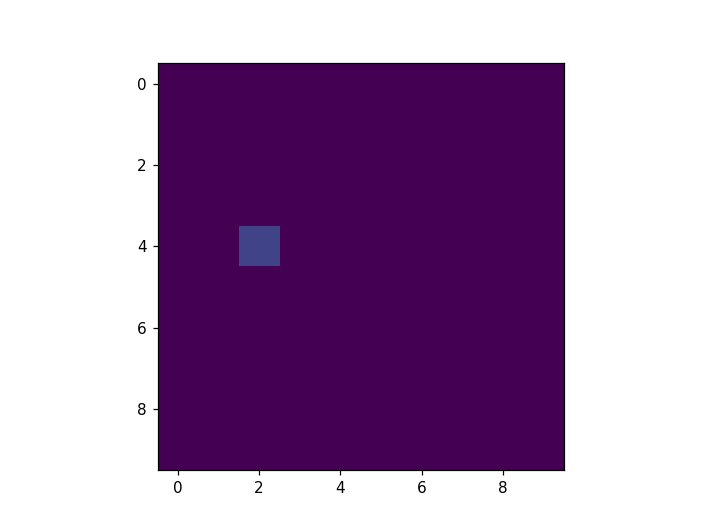

In [32]:
fig = plt.figure()
im = plt.imshow(momentum_object.render(), animated=True)
def updatefig(*args):
    position = momentum_object.get_state_action().reshape(1,4)
    position = torch.clone(position)
    position[:, 0] = position[:, 0] - ((w-1)/2)
    position[:, 1] = position[:, 1] - ((h-1)/2)

    predict_position = encoder(position).detach()[0]
    predict_position[0] = predict_position[0]*(w-1)
    predict_position[1] = predict_position[1]*(h-1)
    predict_position = torch.round(predict_position)
    
    momentum_object.step()
    im.set_array(momentum_object.render(predict_position))
ani = FuncAnimation(fig, updatefig, interval=500, frames=100, blit=True)
# plt.show()

In [25]:
# fig = plt.figure()
# im = plt.imshow(momentum_object.render(), animated=True)
# ============= TEST ===============
position = momentum_object.get_state_action().reshape(1,4)
position = torch.clone(position)
position[:, 0] = position[:, 0] - ((w-1)/2)
position[:, 1] = position[:, 1] - ((h-1)/2)

predict_position = encoder(position).detach()[0]
predict_position[0] = predict_position[0]*(w-1)
predict_position[1] = predict_position[1]*(h-1)
predict_position = torch.round(predict_position)

momentum_object.step()
momentum_object.get_state_action(), predict_position[0],predict_position[1]
# im.set_array(momentum_object.render(predict_position))

(tensor([ 6.,  6., -2.,  1.], device='cuda:0', dtype=torch.float64),
 tensor(6., device='cuda:0', dtype=torch.float64),
 tensor(6., device='cuda:0', dtype=torch.float64))